# Combining FDMTs


In [1]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
import calc11
import numpy as np
from scipy import constants
import fdmt # you'll need to have ../python in  you PYTHONPATH
from graphviz import Digraph


%matplotlib inline

In [43]:
nf = 256 # number of channels - must be a power of 2 currently.
fmax = 1440. #  Freuency of the top of the band in MHz
df = 1.0 # Channel bandwidth in MHz
fmin = fmax - nf*df # Frequency of the bottom of the band in MHz
nd = 1024 # Number of DM trials to do
nt = 512 # Number of samples per block
tsamp = 1.0 # milliseconds
freqs = fmin + np.arange(nf)*df
thefdmt = fdmt.Fdmt(fmin, df, nf, nd, nt) # make FDMT
for s in thefdmt.hist_state_shape:
    print(s)

[256   7 519]
[128  12 524]
[ 64  23 535]
[ 32  44 556]
[ 16  85 597]
[  8 166 678]
[  4 317 829]
[   2  588 1100]
[   1 1024 1536]


(256, 512) 254.80224303304712


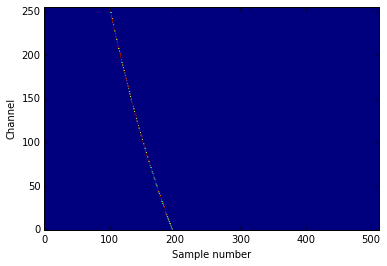

In [44]:
import simfrb # in same directory as fdmt
import importlib
importlib.reload(simfrb)

# I haven't had time to tidy this up - the untis are funny and the FRB is updside down and transposed
# With respect to what the FDMT wants to see - just trust me OK.
# Caution: The DM units here are in pc/cm3 and the DM units the FDMT uses are in samples. at about 1 GHz and 1 ms these are almost identical.
frb = simfrb.mkfrb(fmax/1e3, -df/1e3, nf, tsamp=tsamp, dm=100, ntimes=nt, offset=100).T
frb = np.flipud(frb)
print(frb.shape, frb.sum())
imshow(frb, aspect='auto', origin='lower')
xlabel('Sample number')
ylabel('Channel')

In [45]:
fout = thefdmt(frb) 

In [46]:
def plotfdmt(fout, frb, tsamp, fmin, fmax):
    imshow(fout, origin='lower', aspect='auto')
    hitting_efficiency = fout.max()/frb.sum() # should be close to 1. Ideally 1.
    maxidx = fout.argmax()
    idtmax, tmax = np.unravel_index(maxidx, fout.shape)
    dm_of_idt = idtmax*tsamp/(4.15*((fmin/1e3)**-2 - (fmax/1e3)**-2)) # convert idt to pc/cm3
    print('Hitting efficiency', hitting_efficiency, 'Maximum at t=', tmax, 'idt=', idtmax, '=', dm_of_idt, 'pc/cm3')
    #xlim(100,300)
    #ylim(50,150)
    xlabel('Sample number')
    ylabel('DM trial')

Hitting efficiency 0.8546583166818794 Maximum at t= 196 idt= 96 = 100.10314663532175 pc/cm3


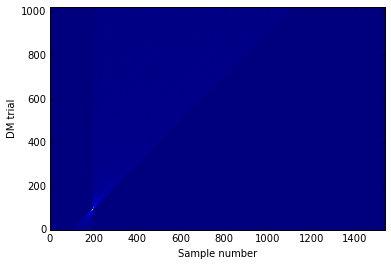

In [47]:
plotfdmt(fout, frb, tsamp, fmin, fmax)

Let's now do it in 2 frequency chunks.

In [61]:
cchunks = ((0, 100), (100, nf+1))

In [62]:
for c1, c2 in cchunks:
    thisnf = c2 - c1
    print(thisnf, frb[c1:c2].shape)

    f = fdmt.Fdmt(fmin + c1*df, df, thisnf, nd, nt)
    
    fout = f(frb[c1:c2, :])

100 (100, 512)


AssertionError: V1 contains nans

Hitting efficiency 0.8546583166818794 Maximum at t= 196 idt= 96 = 100.10314663532175 pc/cm3
Hitting efficiency 0.8546583166818794 Maximum at t= 196 idt= 96 = 100.10314663532175 pc/cm3


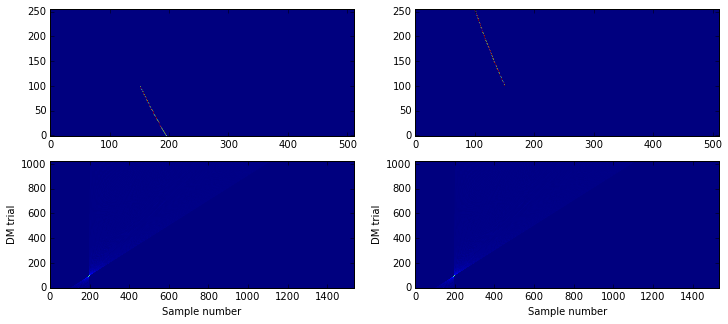

In [68]:
# Dammit - another bug in teh FDMT somewhere. LEt's try doing it with 1 FDMT
fig, ax = subplots(2,2, figsize=(12,5))
allsum = np.zeros(thefdmt.hist_state_shape[-1][1:])
for ichunk, (c1, c2) in enumerate(cchunks):
    thisfrb = np.zeros_like(frb)
    thisfrb[c1:c2,:] = frb[c1:c2,:]
    
    myfout = thefdmt(thisfrb)
    allsum += myfout
    ax[0, ichunk].imshow(thisfrb, origin='lower', aspect='auto')

    plt.sca(ax[1, ichunk])
    plotfdmt(fout, frb, tsamp, fmin, fmax)

Hitting efficiency 0.8546583166818793 Maximum at t= 196 idt= 96 = 100.10314663532175 pc/cm3


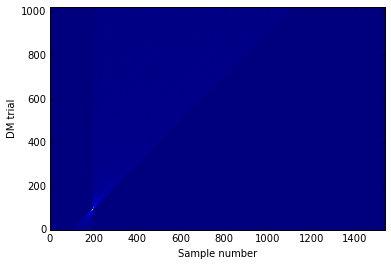

In [69]:
plotfdmt(allsum, frb, tsamp, fmin, fmax)

Hitting efficiency 0.8546583166818794 Maximum at t= 196 idt= 96 = 100.10314663532175 pc/cm3


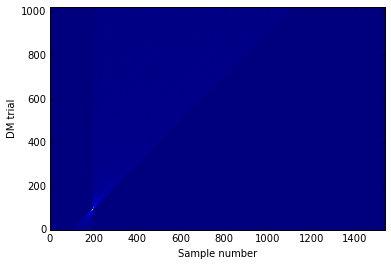

In [70]:
plotfdmt(fout, frb, tsamp, fmin, fmax)

1.3051319613435868e-16


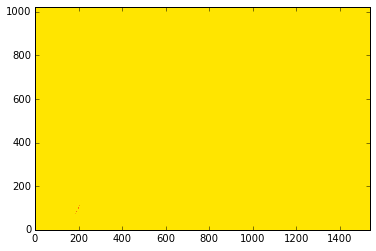

In [71]:
imshow(allsum-fout, origin='lower', aspect='auto')
print(abs(allsum-fout).max()/fout.max())

(180, 200)

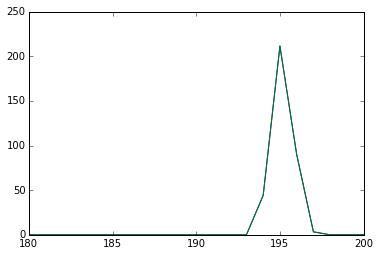

In [72]:
idt = 95
plot(fout[idt, :])
plot(allsum[idt, :])
xlim(180,200)